# Collaborative filtering
- Patrick Schaper ()
- Daniel-Alexandru Bejan (474404)

In [1]:
from IPython.core.display import HTML
from movie_display import movie_display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


## Dataset analysis

In [2]:
# Load into a dataframe
movies = pd.read_csv('./dataset/movies.csv')
links = pd.read_csv('./dataset/links.csv')
ratings = pd.read_csv('./dataset/ratings.csv')
tags = pd.read_csv('./dataset/tags.csv')
df = pd.read_json('./dataset/imdbdata.json', orient='columns')


### Print data 

In [3]:
print(f"Number of ratings: {len(ratings)}")
print(f"Number of unique movieId's: {ratings['movieId'].nunique()}")
print(f"Number of unique users: {ratings['userId'].nunique()}")
print(f"Average number of ratings per user: {round(len(ratings)/ratings['userId'].nunique(), 2)}")
print(f"Average number of ratings per movie: {round(len(ratings)/ratings['movieId'].nunique(), 2)}")

Number of ratings: 100004
Number of unique movieId's: 9066
Number of unique users: 671
Average number of ratings per user: 149.04
Average number of ratings per movie: 11.03


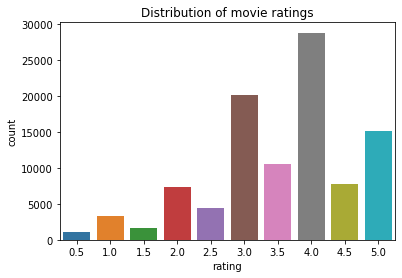

In [4]:
sns.countplot(x="rating", data=ratings)
plt.title("Distribution of movie ratings")
plt.show()

In [5]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.54.
Mean rating per user: 3.66.


In [6]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId'] == lowest_rated]

,movieId,title,genres
1062,1311,Santa with Muscles (1996),Comedy


In [7]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
50,53,Lamerica (1994),Adventure|Drama


In [8]:

movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [9]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [10]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
284,318,311,4.487138,4.446203,"Shawshank Redemption, The (1994)"
695,858,200,4.487500,4.425014,"Godfather, The (1972)"
48,50,201,4.370647,4.314534,"Usual Suspects, The (1995)"
977,1221,135,4.385185,4.302614,"Godfather: Part II, The (1974)"
472,527,244,4.303279,4.259541,Schindler's List (1993)


In [11]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
2869,3593,19,1.210526,1.975099,Battlefield Earth (2000)
1242,1556,23,1.652174,2.183723,Speed 2: Cruise Control (1997)
2161,2701,47,2.031915,2.271446,Wild Wild West (1999)
489,546,17,1.735294,2.347912,Super Mario Bros. (1993)
1243,1562,47,2.148936,2.366224,Batman & Robin (1997)


In [12]:

movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Number of movie genres

In [13]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1117,
         'Animation': 447,
         'Children': 583,
         'Comedy': 3315,
         'Fantasy': 654,
         'Romance': 1545,
         'Drama': 4365,
         'Action': 1545,
         'Crime': 1100,
         'Thriller': 1729,
         'Horror': 877,
         'Mystery': 543,
         'Sci-Fi': 792,
         'Documentary': 495,
         'IMAX': 153,
         'War': 367,
         'Musical': 394,
         'Western': 168,
         'Film-Noir': 133,
         '(no genres listed)': 18})

In [14]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4365), ('Comedy', 3315), ('Thriller', 1729), ('Romance', 1545), ('Action', 1545)]


## User-item matrix

In [15]:
# Create a pivot table with userId as the index, movieId as the columns, and rating as the values
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

In [16]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Similarity metrics

In [152]:
def calculate_similarity(df, similarity='none'):
    """
    Prepare the datafram for the cosine similarity
    Parameters
    ----------
    df : Pandas Dataframe

    similarity : string
    Returns
    -------
     dataframe : Pandas dataframe
    """
    if similarity == 'pearson':
        # centered zero matrix
        # Per slides: Subtract the mean (average) user rating from each user’s rating
        # (substracts the ROW mean)
        # 1. Subtract the average of a user from its ratings
        # 2. The negative values represent negative ratings, positive values represent positive ratings
        # 3. The value 0 is now the average rating for a user
        similarity_matrix = df.subtract(df.mean(axis=1), axis=0)   
    if similarity == 'adjusted':
        # Adjusted cosine similarity
        # Per slides: Subtract the average item rating from each user rating for a given item (when
        # we calculate the difference between users)
        # (substracts the COLUMN mean)
        similarity_matrix = (df - df.mean())
    # Per slides: 
    # Problem: low ratings and high ratings will have the same angle when
    # calculating the cosine similarity
    # ▪ Difference between A and B and A and C is small, whereas A and C are
    # almost opposite users
    # ▪ Solution: center around 0
    # Therefore we have to center everything around 0 filling the NaN values with 0. as follows
    similarity_matrix = df.fillna(0)
    # Calculating the cosine similarity
    similarity = cosine_similarity(similarity_matrix)
    # set the columns and index of the initial dataframe otherwise it would messup the indexes later
    return pd.DataFrame(similarity,index=df.index, columns=df.index)

#### Calculate similarity matrixes

In [153]:
cosine_similarity_matrix = calculate_similarity(user_item_matrix)

pearson_similarity_matrix = calculate_similarity(user_item_matrix, 'pearson')

ajusted_cosine_similarity_matrix = calculate_similarity(user_item_matrix, 'adjusted')

# Example for each similarity

### Cosine Similarity

In [154]:
from sklearn.metrics.pairwise import cosine_similarity
# cosine similarity
cosine_similarity_matrix = calculate_similarity(user_item_matrix)
# calc pearson similarity
pearson_similarity_matrix = calculate_similarity(user_item_matrix, 'pearson')
# calculate adjusted cosine similarity
adjusted_cosine_similarity_matrix = calculate_similarity(user_item_matrix, 'adjusted')

In [155]:
# sns.heatmap(cosine_similarity_matrix, cmap='viridis')
# sns.heatmap(pearson_similarity_matrix, cmap='viridis')
# sns.heatmap(ajusted_cosine_similarity_matrix, cmap='viridis')

#### Calculate the user average

In [156]:

# user_item_matrix.iloc[4][3]
user_item_matrix['average'] = user_item_matrix.mean(axis=1)


## User-user recommendations

#### Converting the user-item matrix to user-user matrix

In [157]:
cosine_similarity_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.022876,0.028151,0.086837,0.036779,0.028945,0.102853,0.018767,0.042203,0.029368,...,0.026142,0.039602,0.023127,0.052271,0.030607,0.024319,0.042958,0.093261,0.034971,0.035902
2,0.022876,1.000000,0.137393,0.125356,0.113388,0.015428,0.221879,0.122038,0.127338,0.058168,...,0.484529,0.082765,0.081984,0.168073,0.474657,0.432898,0.105196,0.041002,0.185758,0.122081
3,0.028151,0.137393,1.000000,0.089969,0.162780,0.078523,0.166391,0.258756,0.151370,0.131724,...,0.175580,0.088404,0.180226,0.162983,0.193606,0.138504,0.149239,0.100538,0.156334,0.180299
4,0.086837,0.125356,0.089969,1.000000,0.136433,0.088220,0.324313,0.195968,0.039839,0.145159,...,0.121754,0.059296,0.139091,0.256314,0.130370,0.095928,0.080991,0.113478,0.065126,0.216459
5,0.036779,0.113388,0.162780,0.136433,1.000000,0.076625,0.105008,0.173151,0.099454,0.045850,...,0.201009,0.039480,0.149595,0.227456,0.152068,0.069130,0.062213,0.053137,0.078070,0.232038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.024319,0.432898,0.138504,0.095928,0.069130,0.016401,0.241258,0.078880,0.082135,0.048740,...,0.352012,0.071912,0.078588,0.128633,0.362294,1.000000,0.113327,0.036460,0.169686,0.137282
668,0.042958,0.105196,0.149239,0.080991,0.062213,0.047921,0.078432,0.128256,0.218087,0.124839,...,0.098064,0.096300,0.099903,0.090200,0.141404,0.113327,1.000000,0.032499,0.206651,0.150796
669,0.093261,0.041002,0.100538,0.113478,0.053137,0.045939,0.087920,0.068435,0.051150,0.081415,...,0.035414,0.055119,0.083686,0.107565,0.051261,0.036460,0.032499,1.000000,0.067935,0.098086


In [76]:
user_id = 1
user_row = cosine_similarity_matrix.loc[1]

updated_df = user_row.drop(1)
updated_df.head()
updated_df.sort_values(ascending=False)

userId
325    0.397932
634    0.226339
341    0.196987
310    0.192574
207    0.170800
         ...   
427    0.011745
402    0.011393
187    0.011116
382    0.011060
475    0.007420
Name: 1, Length: 670, dtype: float64

In [77]:
def get_similar_users(user_id, similarity_strategy='none'):
    """"Create a dict with the most similar users and ranks them based on similarity """
    # get the similarity matrix based similarity strategy
    similarity_matrix = calculate_similarity(user_item_matrix, similarity_strategy)
    # drop the user itself
    similar_users = (similarity_matrix.loc[user_id]).drop(1)
    # sorting the value descending in order to get the most similar users first
    return similar_users.sort_values(ascending=False).head(10)

In [78]:
# # testing the method above
# # user_id= 2
# similar_users = get_similar_users(2)

# similar_users

# # print(similar_users.index.to_list)


# # user_item_matrix.loc[similar_users.index]

# # for user_id, similarity in pd.DataFrame(similar_users).iterrows():
# #     print(user_id)
#     # simlar_user = user_item_matrix.iloc[user_id].dropna()
#     # print(simlar_user)

# # users_movies = pd.DataFrame(user_item_matrix.iloc[lambda x: x % 2 == 0])
# # print(type(users_movies.columns)) 
# # droplist = [column for column in users_movies if 1 >= column <= 5]
# # print(droplist)
# # dropped_columns = users_movies.drop(droplist,inplace=True)

# # dropped_columns.head()

In [150]:
def get_recommendation_list(user_id, number_of_recommendations, similarity_strategy, debug=False):
    # get the similar users with the selected similarity strategy as pandas dataframe
    similar_user_data = get_similar_users(user_id, similarity_strategy)

    # print(similar_users)
    # get pandas dataframe with each users and their movies
    rated_movies_by_user = user_item_matrix.loc[user_id].dropna()
    # users_movies = pd.DataFrame(user_item_matrix.iloc[2])
    recommendations = []
    for user_id, similarity in similar_user_data.items():
        # select the user from the user_item matrix and drop the null values
        similar_user_movies = user_item_matrix.loc[user_id].dropna()
        # print('current user',similar_user_movies.tolist())
        for movie_id, rating in similar_user_movies.items():
            if movie_id not in rated_movies_by_user:
                # print('user_id', user_id, 'movie', movie_id, 'similarity',similarity, 'rating', rating)
                recommendations.append((movie_id, rating * similarity))
    # sort values descending
    # recommendations = initial_recommendation.sort_values(ascending=False).head(number_of_recommendations)
    # # return the movies id only
    # print(recommendations[:30])
    recommendations.sort(key=lambda tup: tup[1], reverse=True)
    # print(recommendations[:10])
    if (debug):
        print(len(recommendations))
        print(recommendations[:10])
    movies = []
    # put the movie ids into a list to be prepared for display in the notebook widgets
    for movie_id, _ in recommendations:
        movies.append(movie_id)
    
    return movies[:number_of_recommendations]

In [149]:
get_recommendation_list(2, 5, 'none', debug=True)

256
[(337, 2.9369527134254527), (318, 2.934262195483864), (21, 2.8935748491542554), (32, 2.8935748491542554), (316, 2.8935748491542554), (329, 2.8935748491542554), (435, 2.8935748491542554), (318, 2.8859310863540495), (594, 2.8859310863540495), (6, 2.8485153285738662)]


[337, 318, 21, 32, 316]

In [103]:
def get_indexes(imdb_id=[]):
    movies = []
    for x in range(len(imdb_id)):
        movieIndex = df.loc[df['imdbId'] == imdb_id[x]].index[0]
        movies.append(df.iloc[movieIndex])
    
    return movies

In [104]:
def displayRecommendations(recommendations=[]):
    movies = []
    for _, row in links.iterrows():
        if row['movieId'] in recommendations:
            movies.append(int(row['imdbId']))
    
    return get_indexes(movies)

In [106]:
# display(displayRecommendations([589, 1196]))

# movies = [df.iloc[522], df.iloc[953]]\
recommendations = displayRecommendations([337, 318, 21])
print(type(recommendations)) 
HTML(movie_display.show(recommendations))

<class 'list'>


### Widgets

In [159]:
from IPython.core.display_functions import clear_output
import ipywidgets as widgets

selected_user = widgets.Dropdown(
    options=list(x+1 for x in range(ratings['userId'].nunique())),
    description='Select a user:\n ',
    disabled=False,
    layout={'width': 'max-content'}
)
recommendations = widgets.IntText(
    min=0,
    value=3,
    description='Number of recommendations:\n ',
    disabled=False,
)
similarity_strategy = widgets.RadioButtons(
    options=[('Cosine',0), ('Pearson',1), ('Adjusted cosine',2)],
    description='Similarity metrics:',
    disabled=False
)
button = widgets.Button(
    description='Recommendation',
    disabled=False,
)

def execute_function(_):
    with out:
          clear_output()
          recommendation_titles = []
          if similarity_strategy.value == 0:
              recommendation_list = get_recommendation_list(selected_user.value, recommendations.value, similarity_strategy='none')
          if similarity_strategy.value == 1:
              recommendation_list = get_recommendation_list(selected_user.value, recommendations.value, similarity_strategy='pearson')
          if similarity_strategy.value == 2:
              recommendation_list = get_recommendation_list(selected_user.value, recommendations.value, similarity_strategy='adjusted')

          print(f'Selected User: {selected_user.value}')
          print('Recommendation(s):')
          print(f'Got movies with the following ids as recommendations: {recommendation_list}')
          display(HTML(movie_display.show(displayRecommendations(recommendation_list))))
            
button.on_click(execute_function)
out = widgets.Output()

box = widgets.VBox([selected_user, similarity_strategy, recommendations, button, out])
box

## Item-item recommendations

1. Select a user
2. Select the movies that the user has rated more than 3.5 stars
3. Based on the user 

Give N (configurable) recommendations for a given user U (configurable) based on the
movies the user U rated with at least 3.5 stars. Explain your implementation and the
strategy that you use for selecting the final recommendations.
Which means that we have to give the user N number of recommendations for a certain user(selectable) from the movies that he has rated with at least 3.5 stars.

In the UI we would have to:
1. N number of recommendations
2. U which user id
3. Select certain movie which is rated >= 3.5 stars

How to do the recommendations:
1. find similar items
2. Candidate selection (items you might recommend)
3. Score recommendation candidates
4. Filter candidates (top_n) recommendation

In [163]:
# Create item_user matrix
# The difference between the user_item matrix is that the movie id will be the index and the columns would be the user id
# Which means that when we calculated the similarity matrix we would calculate the mean and using the ratings from the users 
# Per slides: Both(pearson and adjusted cosine similarity) are applicable for user-user and item-item recommendations
# Simply switch around users and items in the formulas!
item_user_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

item_user_matrix.head(20)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculating the similarity matrixes

In [164]:
# cosine similarity
item_item_cosine_similarity_matrix = calculate_similarity(item_user_matrix)
# calc pearson similarity
item_item_pearson_similarity_matrix = calculate_similarity(item_user_matrix, 'pearson')
# calculate adjusted cosine similarity
item_item_adjusted_cosine_similarity_matrix = calculate_similarity(item_user_matrix, 'adjusted')

In [165]:
item_item_pearson_similarity_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.000000,0.425462,0.124562,0.088735,0.058252,0.000000,0.232051,0.069005,0.066412,0.032653,...,0.342283,0.050754,0.074080,0.124214,0.351207,1.000000,0.091597,0.018416,0.153111,0.127995
668,0.000000,0.084646,0.124911,0.068483,0.042926,0.019563,0.058773,0.112366,0.194493,0.098561,...,0.074089,0.059010,0.093021,0.082525,0.114487,0.091597,1.000000,0.000000,0.178017,0.135387
669,0.062917,0.024140,0.080984,0.104309,0.038358,0.024583,0.073151,0.055143,0.029291,0.060549,...,0.015960,0.025953,0.077927,0.101707,0.028773,0.018416,0.000000,1.000000,0.042609,0.085202


In [32]:
from IPython.core.display_functions import clear_output
import ipywidgets as widgets

selected_user = widgets.Dropdown(
    options=list(x+1 for x in range(ratings['userId'].nunique())),
    description='Select a user:\n ',
    disabled=False,
    layout={'width': 'max-content'}
)
recommendations = widgets.IntText(
    min=0,
    value=3,
    description='Number of recommendations:\n ',
    disabled=False,
)
selected_user_movie = widgets.Dropdown(
    options=list(x+1 for x in range(ratings['userId'].nunique())),
    description='Select a movie that the user has rated:\n ',
    disabled=False,
    layout={'width': 'max-content'}
)
similarity_strategy = widgets.RadioButtons(
    options=[('Cosine',0), ('Pearson',1), ('Adjusted cosine',2)],
    description='Similarity metrics:',
    disabled=False
)
button = widgets.Button(
    description='Recommendation',
    disabled=False,
)

def execute_function(_):
    with out:
          clear_output()
          recommendation_titles = []
          if similarity_strategy.value == 0:
              recommendation_list = get_recommendation_list(selected_user.value, recommendations.value, similarity_strategy='none')
          if similarity_strategy.value == 1:
              recommendation_list = get_recommendation_list(selected_user.value, recommendations.value, similarity_strategy='pearson')
          if similarity_strategy.value == 2:
              recommendation_list = get_recommendation_list(selected_user.value, recommendations.value, similarity_strategy='adjusted')

          print(f'Selected User: {selected_user.value}')
            
          print('Recommendation(s):')
          print(f'Got movies with the following ids as recommendations: {recommendation_list}')
          display(HTML(movie_display.show(displayRecommendations(recommendation_list))))
            
button.on_click(execute_function)
out = widgets.Output()

box = widgets.VBox([recommendations, selected_user, selected_user_movie, similarity_strategy, button, out])
box